<a href="https://colab.research.google.com/github/bernarddjoko/ai-cancer-diagnosis-assistant/blob/dev-image/resnet50_gradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Environment Setup & Imports

In [ ]:
# Step 1: Environment setup
!pip install torch torchvision matplotlib --quiet

# Step 2: Imports
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.4 MB/s eta 0:00:00


Download & Display a Sample Chest X-ray

--2025-07-13 23:22:15--  https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/images/1-s2.0-S0929664620300449-gr2_lrg-b.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276425 (270K) [image/jpeg]
Saving to: ‘chest_xray.jpg’

chest_xray.jpg      100%[===================>] 269.95K  --.-KB/s    in 0.04s   

2025-07-13 23:22:16 (6.42 MB/s) - ‘chest_xray.jpg’ saved [276425/276425]



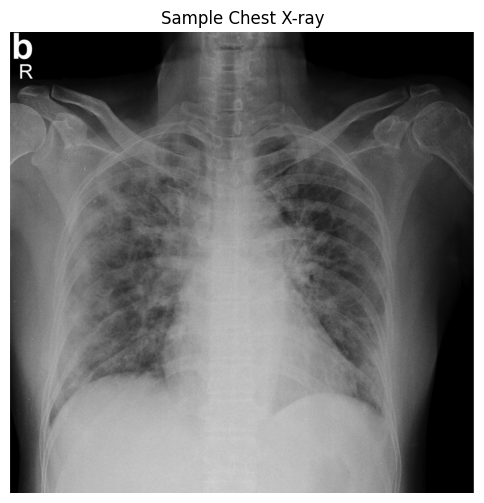

In [ ]:
# Step 3: Download a sample chest X-ray image
!wget https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/images/1-s2.0-S0929664620300449-gr2_lrg-b.jpg -O chest_xray.jpg

# Step 4: Load and display the image
image = Image.open("chest_xray.jpg").convert("RGB")

plt.figure(figsize=(6,6))
plt.imshow(image)
plt.title("Sample Chest X-ray")
plt.axis("off")
plt.show()

Preprocess & Run Through ResNet-50

In [ ]:
# Step 3: Load and preprocess the image
from torchvision import transforms
from PIL import Image

# Define transform (match ResNet input requirements: 224x224, normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load and transform image
img = Image.open("chest_xray.jpg").convert("RGB")
input_tensor = transform(img).unsqueeze(0)  # Add batch dimension

 Run Through ResNet-50 and Extract Features

In [ ]:
# Step 4: Load pretrained ResNet-50
model = models.resnet50(pretrained=True)
model.eval()  # Set to evaluation mode

# Step 5: Run the image through ResNet-50
with torch.no_grad():
    output = model(input_tensor)

# Step 6: Get prediction label
pred_class = torch.argmax(output, dim=1).item()
print(f"Predicted class index: {pred_class}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 106MB/s]


Predicted class index: 562


In [ ]:
# Step 7: Extract features from second-last layer
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])  # Remove the classification layer

with torch.no_grad():
    features = feature_extractor(input_tensor)

print(f"Extracted feature shape: {features.shape}")

Extracted feature shape: torch.Size([1, 2048, 1, 1])


Grad-CAM for ResNet-50

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


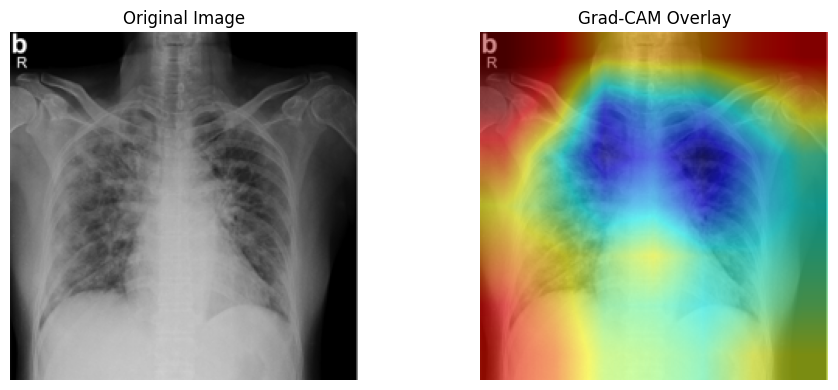

In [ ]:
# Step 8: Grad-CAM visualization

import cv2
import torch.nn.functional as F

# Choose the last convolutional layer
target_layer = model.layer4[-1]

# Store the gradients and activations
gradients = []
activations = []

def save_gradient(module, grad_input, grad_output):
    gradients.append(grad_output[0])

def save_activation(module, input, output):
    activations.append(output)

# Register hooks
handle_activ = target_layer.register_forward_hook(save_activation)
handle_grad = target_layer.register_backward_hook(save_gradient)

# Forward pass
model.zero_grad()
output = model(input_tensor)
pred_class = output.argmax(dim=1)
score = output[0, pred_class]
score.backward()

# Get stored values
gradients = gradients[0]
activations = activations[0]

# Compute weights and Grad-CAM
weights = gradients.mean(dim=(2, 3), keepdim=True)
cam = (weights * activations).sum(dim=1, keepdim=True)
cam = F.relu(cam)
cam = F.interpolate(cam, size=(224, 224), mode='bilinear', align_corners=False)
cam = cam.squeeze().detach().numpy()

# Normalize and overlay on original image
cam -= cam.min()
cam /= cam.max()
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255

# Load original image again (as numpy)
orig = np.array(img.resize((224, 224))) / 255.0
overlay = heatmap + orig
overlay = overlay / overlay.max()

# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(orig)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("Grad-CAM Overlay")
plt.axis("off")
plt.tight_layout()
plt.show()

# Clean up
handle_activ.remove()
handle_grad.remove()